In [1]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model, Sequential
from keras.layers import Input, Dense
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

import numpy as np
from keras.utils.np_utils import to_categorical
import glob
import os

Using TensorFlow backend.


In [2]:
categories = ['0_buildings', '1_forest', '2_glacier', '3_mountain', '4_sea', '5_street']

In [3]:
train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                         width_shift_range=0.25,
                                         height_shift_range=0.25,
                                         shear_range=0.01,
                                         zoom_range=[0.75, 1.25],
                                         horizontal_flip=True,
                                         vertical_flip=False,
                                         data_format='channels_last',
                                         fill_mode='reflect',
                                         brightness_range=[0.75, 1.25]
                                         )

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory='C:/Datasets/scene-classification/data/train/',
    target_size=(299, 299),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 15780 images belonging to 6 classes.


In [5]:
valid_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                         width_shift_range=0.25,
                                         height_shift_range=0.25,
                                         shear_range=0.01,
                                         zoom_range=[0.75, 1.25],
                                         horizontal_flip=True,
                                         vertical_flip=False,
                                         data_format='channels_last',
                                         fill_mode='reflect',
                                         brightness_range=[0.75, 1.25]
                                        )

In [6]:
valid_generator = valid_datagen.flow_from_directory(
    directory='C:/Datasets/scene-classification/data/valid/',
    target_size=(299, 299),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 1254 images belonging to 6 classes.


In [7]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

In [8]:
input_tensor = Input(shape=(299, 299, 3))
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=(299, 299, 3), pooling='avg', classes=1000)
for layer in base_model.layers[:-13]:
    layer.trainable = False
    
t = base_model(input_tensor)
output_tensor = Dense(len(categories), activation='softmax')(t)
model = Model(inputs=input_tensor, outputs=output_tensor)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 9222      
Total params: 54,345,958
Trainable params: 4,711,398
Non-trainable params: 49,634,560
_________________________________________________________________


In [9]:
from lr_finder import LRFinder
from keras.callbacks import ModelCheckpoint, TensorBoard

In [10]:
file_path = 'C:/Datasets/scene-classification/models/'
model_name = 'irnv2_lrfind_adam.hdf5'
checkpoint = ModelCheckpoint(file_path + model_name, monitor='val_categorical_accuracy', save_best_only=True, verbose=1, mode='max')
tb = TensorBoard(log_dir='C:/Datasets/scene-classification/logs/')

```python
steps_per_epoch = 493
```

In [11]:
lrf = LRFinder(min_lr=3e-6, max_lr=1e-2, steps_per_epoch=STEP_SIZE_TRAIN, epochs=4)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [13]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[lrf, checkpoint, tb],
                    epochs=4,
                    verbose=1
                   )

Epoch 1/4
986/986 [==============================] - 408s 414ms/step - loss: 0.5351 - categorical_accuracy: 0.8047 - val_loss: 1.1011 - val_categorical_accuracy: 0.7300

Epoch 00001: val_categorical_accuracy improved from -inf to 0.72997, saving model to C:/Datasets/scene-classification/models/irnv2_lrfind_adam.hdf5
Epoch 2/4
986/986 [==============================] - 400s 405ms/step - loss: 0.4405 - categorical_accuracy: 0.8402 - val_loss: 0.5843 - val_categorical_accuracy: 0.8126

Epoch 00002: val_categorical_accuracy improved from 0.72997 to 0.81260, saving model to C:/Datasets/scene-classification/models/irnv2_lrfind_adam.hdf5
Epoch 3/4
986/986 [==============================] - 398s 404ms/step - loss: 0.3976 - categorical_accuracy: 0.8578 - val_loss: 0.3979 - val_categorical_accuracy: 0.8700

Epoch 00003: val_categorical_accuracy improved from 0.81260 to 0.86995, saving model to C:/Datasets/scene-classification/models/irnv2_lrfind_adam.hdf5
Epoch 4/4
986/986 [=====================

In [17]:
model.save(file_path + 'irnv2_lrfind_adam_e3.hdf5')

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

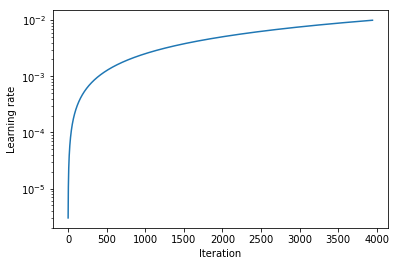

In [16]:
lrf.plot_lr()

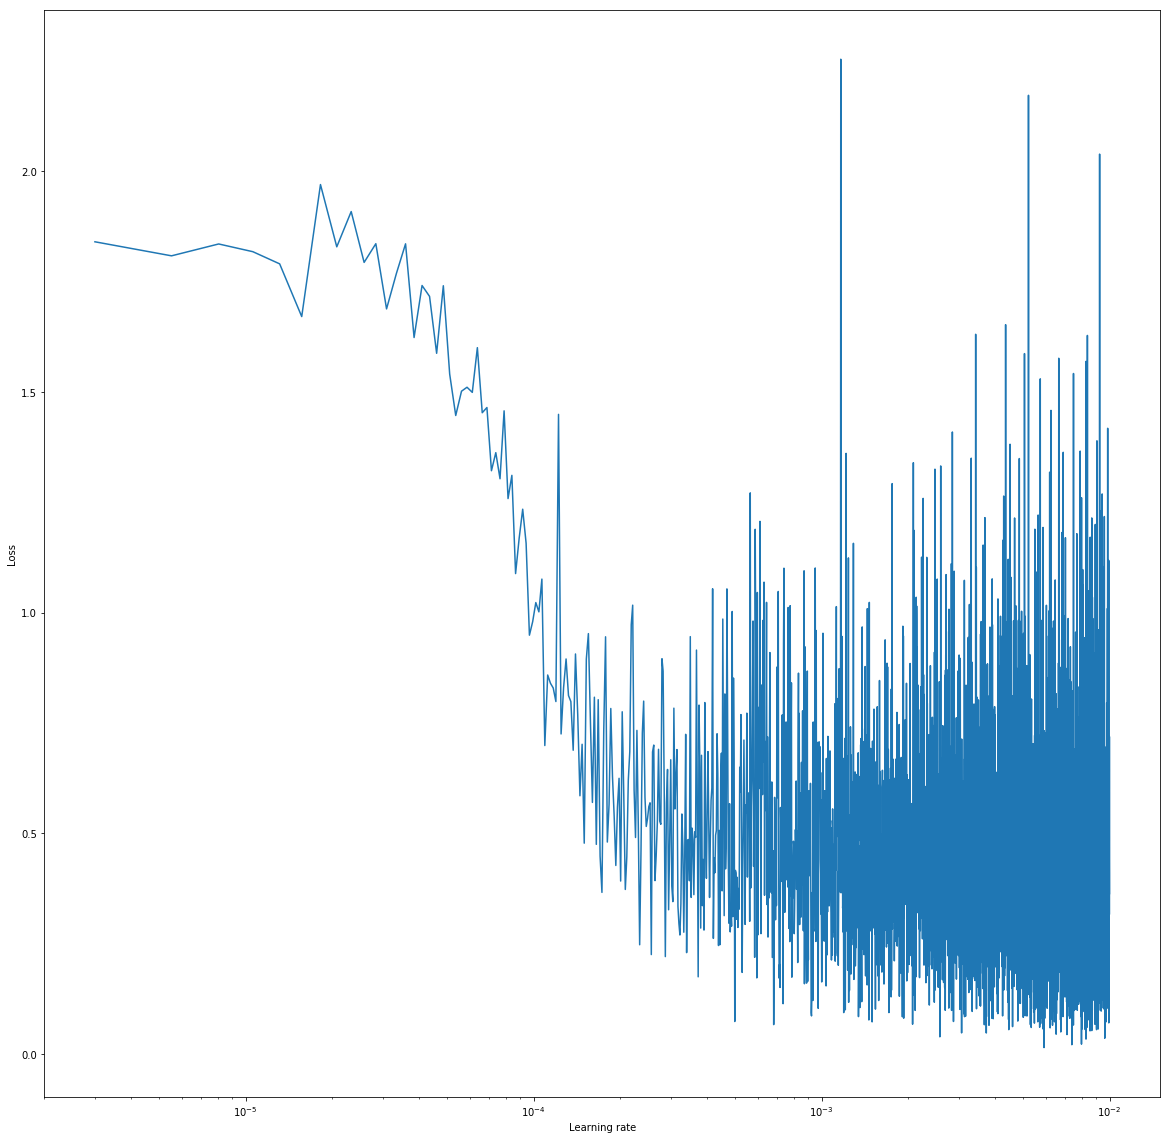

In [18]:
plt.figure(figsize=(20, 20))
lrf.plot_loss()

## 3.16e-4 - 3.16e-5

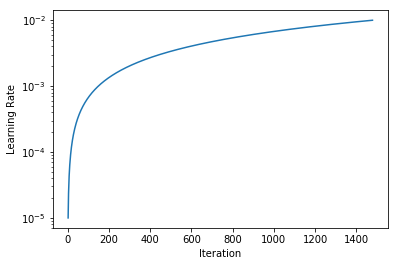

In [24]:
plt.plot(lrf.history['iterations'], lrf.history['lr'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.show()